https://molefrog.github.io/pidnn-talk/#pidnn-controller

Use neural network to generate PID parameters. Neural network is trained using a model of the plant so we don't need to know jacobian of plant. Model is trained on plant outputs offline.

V3.1 PID neural network takes in previous y value as parameter

V3.2 Take absolute value of Kp, Ki, Kd

V3.3 PID control the plant while training with a manually tuned PID controller

V3.4 Remove 3.3 changes. Initialize bias term with ones

V3.5 Added another layer to model neural network. Initialized only model nn with zeros. Increased NN model size to 16

In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
import tensorflow as tf
from tensorflow.python.framework import ops

In [2]:
d_t = 0.01
d_t_decimal = str(d_t)[::-1].find('.')
steps = 3000

In [3]:
class PID:
    def __init__(self, Kp=0, Ki=0, Kd=0):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.I_max = 5
        self.e = 0
        self.t = 0
        self.e_prev = 0
        self.t_prev = 0
        self.P = 0
        self.I = 0
        self.D = 0
        self.u = 0
        
    def set_state(self, e, t):
        self.e = e
        self.t = t
        
    def update(self, Kp, Ki, Kd):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        
        delta_time = self.t - self.t_prev
        delta_error = self.e - self.e_prev
        
        self.P = e
        
        self.I += e * delta_time

        if (self.I < -self.I_max):
            self.I = -self.I_max
        elif (self.I > self.I_max):
            self.I = self.I_max

        if delta_time > 0:
            self.D = delta_error / delta_time
        else:
            self.D = 0

        self.t_prev = self.t
        self.e_prev = self.e

        self.u = self.Kp * self.P + self.Ki * self.I + self.Kd * self.D
        return np.float32(self.u)
        
    def d_update(self, Kp, Ki, Kd):
        return np.float32(self.P), np.float32(self.I), np.float32(self.D)
    
    def reset(self):
        self.e = 0
        self.t = 0
        self.e_prev = 0
        self.t_prev = 0
        self.P = 0
        self.I = 0
        self.D = 0
        self.u = 0


In [4]:
def plant_process(y, t, u):
    K = 0.01
    tau = 1.0
    T = 0.2
    
    t_delay = round(t-T, d_t_decimal)
    if (t_delay<= 0) or (t_delay<0.0):
        u_delay = u[0]
    else:
        step_t = int(t_delay/d_t)-1
        if step_t >= steps:
            u_delay = u[-1]
        else: 
            u_delay = u[step_t]  
        
    dydt = (-y + K*u_delay)/tau
    return dydt

def plant(y_0, t1, t2, u):
    ts = [t1, t2]
    return odeint(plant_process, y_0, ts, args=(u,))[1]

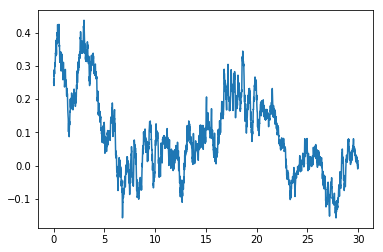

In [5]:
interval = 200
r_steps = steps//interval

r_sq = np.zeros(steps)
up = -1

for i in range(r_steps):
    if i < r_steps-1:
        r_sq[i * interval:(i+1)*interval] = up
    else:
        r_sq[i * interval:] = up
    if up > 0:
        up = -1
    else:
        up = 1

t = np.linspace(0, d_t*steps, steps)
r_sin = np.sin(t)

def gen_rand_sig(t):
    N = 1000
    x = np.random.normal(scale=10.0, size=len(t))
    return np.convolve(x, np.ones((N,))/N)[(N-1):] 
    
r_rand = gen_rand_sig(t)
plt.plot(t, r_rand)

### Plant control with neural network

In [9]:
pid = PID()

np_update = np.vectorize(pid.update)
np_d_update = np.vectorize(pid.d_update)

def tf_d_update(Kp, Ki, Kd,name=None):
    with tf.name_scope(name, "d_update", [Kp, Ki, Kd]) as name:
        y = tf.py_func(np_d_update,
                        [Kp, Ki, Kd],
                        (tf.float32, tf.float32, tf.float32),
                        name=name,
                        stateful=False)
        return y

def py_func(func, inp, Tout, stateful=True, name=None, grad=None):

    # Need to generate a unique name to avoid duplicates:
    rnd_name = 'PyFuncGrad' + str(np.random.randint(0, 1E+8))

    tf.RegisterGradient(rnd_name)(grad)  # see _MySquareGrad for grad example
    g = tf.get_default_graph()
    with g.gradient_override_map({"PyFunc": rnd_name}):
        return tf.py_func(func, inp, Tout, stateful=stateful, name=name)
    
def updategrad(op, grad):
    Kp, Ki, Kd = op.inputs
    
    dudKp, dudKi, dudKd = tf_d_update(Kp, Ki, Kd)
    return grad * dudKp, grad * dudKi, grad * dudKd


def tf_update(Kp, Ki, Kd, name=None):

    with tf.name_scope(name, "update", [Kp, Ki, Kd]) as name:
        y = py_func(np_update,
                        [Kp, Ki, Kd],
                        [tf.float32],
                        name=name,
                        grad=updategrad)  # <-- here's the call to the gradient
        return y[0]

hl_size_model = 16
hl_size_controller = 3

graph = tf.Graph()
with graph.as_default():
    
    tf_r = tf.placeholder(tf.float32,shape=())
    tf_y = tf.placeholder(tf.float32,shape=())
    tf_learning_rate = tf.placeholder(tf.float32, shape=())

              
    # Model NN    
    wm_1 = tf.Variable(tf.truncated_normal([1, hl_size_model]))
    bm_1 = tf.Variable(tf.zeros([hl_size_model]))   
    wm_2 = tf.Variable(tf.truncated_normal([hl_size_model, hl_size_model]))
    bm_2 = tf.Variable(tf.zeros([hl_size_model]))
    wm_3 = tf.Variable(tf.truncated_normal([hl_size_model, 1]))
    bm_3 = tf.Variable(tf.zeros([1]))
    
    # PID param NN
    wpid_1 = tf.Variable(tf.truncated_normal([2, hl_size_controller]))
    bpid_1 = tf.Variable(tf.ones([hl_size_controller]))   
    wpid_2 = tf.Variable(tf.truncated_normal([hl_size_controller, 3]))
    bpid_2 = tf.Variable(tf.ones([3]))

    
    # Forward prop model offline
    z2 = tf.matmul(tf.reshape(tf_r, (1, 1)), wm_1) + bm_1
    a2 = tf.nn.sigmoid(z2) #Switched from relu to sigmoid works really well
    z3 = tf.matmul(a2, wm_2) + bm_2
    a3 = tf.nn.sigmoid(z3)
    y_model_offline = tf.matmul(a3, wm_3) + bm_3
       
    # Forward prop PID
    X = tf.stack([tf_y, tf_r], 0) 
    z2 = tf.matmul(tf.reshape(X, (1, 2)), wpid_1) + bpid_1
    a2 = tf.nn.relu(z2)
    pid_params = tf.matmul(a2, wpid_2) + bpid_2
    Kp, Ki, Kd = tf.split(pid_params, 3, 1)
    
    Kp = tf.math.abs(Kp)
    Ki = tf.math.abs(Ki)
    Kd = tf.math.abs(Kd)
    
    u_nn = tf_update(Kp, Ki, Kd)
    
    # Forward prop model online
    z2 = tf.matmul(u_nn, wm_1) + bm_1
    a2 = tf.nn.sigmoid(z2) #Switched from relu to sigmoid works really well
    z3 = tf.matmul(a2, wm_2) + bm_2
    a3 = tf.nn.sigmoid(z3)
    y_model_online = tf.matmul(a3, wm_3) + bm_3

    
    model_loss = tf.losses.mean_squared_error(tf_y, tf.reshape(y_model_offline, ()))
    model_opt = tf.train.GradientDescentOptimizer(tf_learning_rate).minimize(model_loss, 
                                                                            var_list=[wm_1, bm_1, wm_2, bm_2, wm_3, bm_3])
    
    pid_loss = tf.losses.mean_squared_error(tf_r, tf.reshape(y_model_online, ()))
    pid_opt = tf.train.GradientDescentOptimizer(tf_learning_rate).minimize(pid_loss, 
                                                                            var_list=[wpid_1, bpid_1, wpid_2, bpid_2])
    

In [10]:
y_0 = 0
y_p_offline = np.zeros(steps)
y_m_offline = np.zeros(steps)

y_p_online = np.zeros(steps)
y_m_online = np.zeros(steps)
u_offline = np.zeros(steps)
u_online = np.zeros(steps)

Kp = np.zeros(steps)
Ki = np.zeros(steps)
Kd = np.zeros(steps)

offline_loss = np.zeros(steps)
online_loss = np.zeros(steps)

r_offline = r_sq
r_online = r_sq


learning_rate = 0.1

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    for i in range(len(t))[1:]:
        t_prev = t[i-1]
        t_cur = t[i]
        
        # Get plant output
        y_p_offline[i] = plant(y_0, t_prev, t_cur, r_offline)
        # Train model on plant output
        feed_dict = {tf_y:y_p_offline[i], tf_r:r_offline[i], tf_learning_rate:learning_rate}
        _, offline_loss[i], y_m_offline[i] = session.run([model_opt, model_loss, y_model_offline], 
                                                         feed_dict=feed_dict)

        y_0 = y_p_offline[i]
#     print("Start online")
    y_0 = 0
    pid.reset()
    for i in range(len(t))[1:]:  
        
        e = r_online[i] - y_p_online[i-1]
        t_prev = t[i-1]
        t_cur = t[i]
        pid.set_state(e, t_cur)
        
        # Get get PID parameters and get control signal
        # Send to model to train PID param NN
        feed_dict = {tf_y:y_p_online[i-1], tf_r:r_online[i], tf_learning_rate:learning_rate}
        _, online_loss[i], y_m_online[i], u_online[i] = session.run([pid_opt, pid_loss, y_model_online, u_nn], 
                                                feed_dict=feed_dict)
        Kp[i] = pid.Kp
        Ki[i] = pid.Ki
        Kd[i] = pid.Kd
        
        y_p_online[i] = plant(y_0, t_prev, t_cur, u_online)
        y_0 = y_p_online[i]

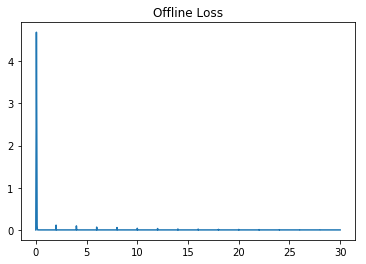

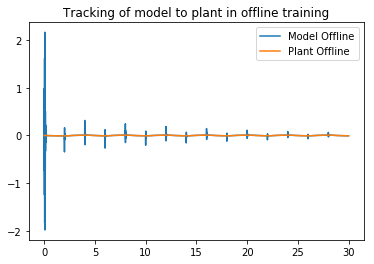

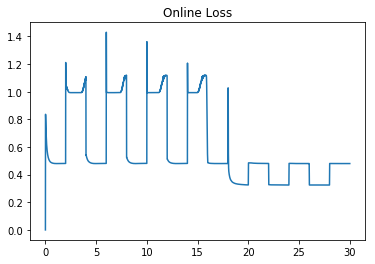

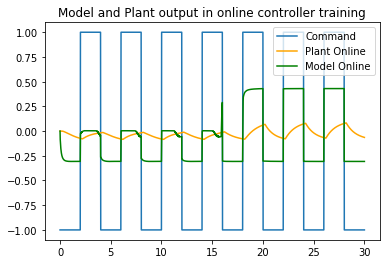

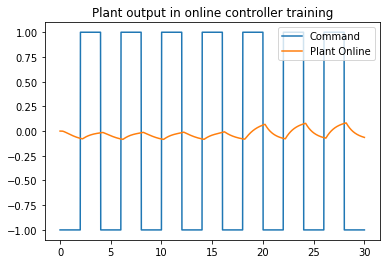

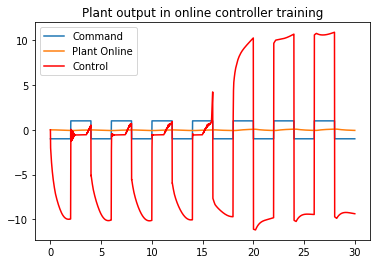

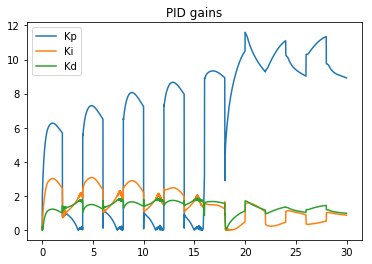

In [11]:
plt.plot(t, offline_loss)
plt.title('Offline Loss')
plt.show()

plt.plot(t, y_m_offline)
plt.plot(t, y_p_offline)
plt.title('Tracking of model to plant in offline training')
plt.legend(('Model Offline', 'Plant Offline'))
plt.show()

plt.plot(t, online_loss)
plt.title('Online Loss')
plt.show()

plt.plot(t, r_online)
plt.plot(t, y_p_online, color='orange')
plt.plot(t, y_m_online, color='green')
plt.title('Model and Plant output in online controller training')
plt.legend(('Command', 'Plant Online', 'Model Online'))
plt.show()

plt.plot(t, r_online)
plt.plot(t, y_p_online)
plt.title('Plant output in online controller training')
plt.legend(('Command', 'Plant Online'))
plt.show()

plt.plot(t, r_online)
plt.plot(t, y_p_online)
plt.plot(t, u_online, color='red')
plt.title('Plant output in online controller training')
plt.legend(('Command', 'Plant Online', 'Control'))
plt.show()

plt.plot(t, Kp)
plt.plot(t, Ki)
plt.plot(t, Kd)
plt.title('PID gains')
plt.legend(('Kp', 'Ki', 'Kd'))
plt.show()